In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import time


In [2]:
# SECTION 1: CLASSE DE BASE ENVIRONNEMENT

from abc import ABC, abstractmethod

class BaseEnvironment(ABC):
    
    @abstractmethod
    def reset(self):
        pass
    
    @abstractmethod
    def step(self, action, is_dynamic_programming=False):
        pass
    
    @property
    @abstractmethod
    def _build_transition_matrix(self):
        pass
    
    @property
    @abstractmethod
    def _build_reward_matrix(self):
        pass


In [3]:
# SECTION 2: UTILITAIRES POUR SAUVEGARDE

import pickle
import json
import os
from typing import Any, Dict, Union, Optional
import warnings

try:
    import joblib
    JOBLIB_AVAILABLE = True
except ImportError:
    JOBLIB_AVAILABLE = False
    warnings.warn("joblib n'est pas disponible. Utilisation de pickle par défaut.")

def save_model(data: Dict[str, Any], filepath: str, format: str = 'pickle') -> None:
    """Sauvegarde un modèle dans le format spécifié."""
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    
    if format == 'pickle':
        with open(filepath, 'wb') as f:
            pickle.dump(data, f)
    elif format == 'joblib':
        if not JOBLIB_AVAILABLE:
            raise ImportError("joblib n'est pas disponible.")
        joblib.dump(data, filepath)
    else:
        raise ValueError(f"Format '{format}' non supporté.")

def load_model(filepath: str, format: str = 'auto') -> Dict[str, Any]:
    """Charge un modèle depuis le format spécifié."""
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Le fichier {filepath} n'existe pas.")
    
    if format == 'auto':
        extension = os.path.splitext(filepath)[1].lower()
        format = 'pickle' if extension == '.pkl' else 'joblib'
    
    if format == 'pickle':
        with open(filepath, 'rb') as f:
            return pickle.load(f)
    elif format == 'joblib':
        if not JOBLIB_AVAILABLE:
            raise ImportError("joblib n'est pas disponible.")
        return joblib.load(filepath)
    else:
        raise ValueError(f"Format '{format}' non supporté.")


C:\Users\Hugo HOUNTONDJI\AppData\Local\Temp\ipykernel_43572\3572104522.py:14: UserWarning: joblib n'est pas disponible. Utilisation de pickle par défaut.
  warnings.warn("joblib n'est pas disponible. Utilisation de pickle par défaut.")


In [4]:
# SECTION 3: ALGORITHME POLICY ITERATION

from typing import Dict, Tuple, Optional, Any, List

class PolicyIteration:
    """
    Implémentation de l'algorithme Policy Iteration.
    
    Policy Iteration alterne entre l'évaluation de politique et l'amélioration
    de politique jusqu'à convergence vers la politique optimale.
    """
    
    def __init__(self, env: Any, gamma: float = 0.9, theta: float = 1e-6):
        """
        Initialise Policy Iteration.
        
        Args:
            env: Environnement MDP
            gamma: Facteur de discount
            theta: Seuil de convergence pour l'évaluation de politique
        """
        self.env = env
        self.gamma = gamma
        self.theta = theta
        self.V = None
        self.policy = None
        self.history = []
        
    def policy_evaluation(self, policy: np.ndarray) -> np.ndarray:
        """
        Évalue une politique donnée.
        
        Args:
            policy: Politique à évaluer (actions pour chaque état)
            
        Returns:
            Fonction de valeur d'état
        """
        V = np.copy(self.V) if self.V is not None else np.random.random((self.n_states,))
        
        # Les états terminaux ont une valeur de 0
        if hasattr(self, 'terminal_states'):
            V[self.terminal_states] = 0.0
        
        while True:
            delta = 0.0
            
            for s in self.states:
                v = V[s]
                total = 0.0
                
                # Calculer la valeur pour l'action dictée par la politique
                action = policy[s]
                
                if hasattr(self, 'reward_matrix') and self.reward_matrix is not None:
                    # Nouveau format avec reward_matrix (même logique que ValueIteration)
                    for s_p in self.states:
                        prob = self.transition_probs[s, action, s_p]
                        reward = self.reward_matrix[s, action]
                        total += prob * (reward + self.gamma * V[s_p])
                else:
                    # Ancien format avec récompenses multiples
                    for s_p in self.states:
                        for r_index in range(len(self.rewards)):
                            r = self.rewards[r_index]
                            prob = self.transition_probs[s, action, s_p, r_index]
                            total += prob * (r + self.gamma * V[s_p])
                
                V[s] = total
                abs_diff = np.abs(v - V[s])
                delta = np.maximum(delta, abs_diff)
            
            if delta < self.theta:
                break
        
        return V
        
    def policy_improvement(self, V: np.ndarray) -> np.ndarray:
        """
        Améliore la politique basée sur la fonction de valeur.
        
        Args:
            V: Fonction de valeur d'état
            
        Returns:
            Politique améliorée
        """
        new_policy = np.copy(self.policy)
        policy_stable = True
        
        for s in self.states:
            old_action = new_policy[s]
            best_action = None
            best_score = -np.inf
            
            # Évaluer toutes les actions possibles
            for a in self.actions:
                score = 0.0
                
                if hasattr(self, 'reward_matrix') and self.reward_matrix is not None:
                    # Nouveau format avec reward_matrix (même logique que ValueIteration)
                    for s_p in self.states:
                        prob = self.transition_probs[s, a, s_p]
                        reward = self.reward_matrix[s, a]
                        score += prob * (reward + self.gamma * V[s_p])
                else:
                    # Ancien format avec récompenses multiples
                    for s_p in self.states:
                        for r_index in range(len(self.rewards)):
                            r = self.rewards[r_index]
                            prob = self.transition_probs[s, a, s_p, r_index]
                            score += prob * (r + self.gamma * V[s_p])
                
                if best_action is None or score > best_score:
                    best_action = a
                    best_score = score
            
            if best_action != old_action:
                policy_stable = False
            
            new_policy[s] = best_action
        
        return new_policy, policy_stable
        
    def train(self, max_iterations: int = 1000) -> Dict[str, Any]:
        """
        Entraîne l'algorithme Policy Iteration.
        
        Args:
            max_iterations: Nombre maximum d'itérations
            
        Returns:
            Dictionnaire contenant les résultats d'entraînement
        """
        # Initialiser les structures nécessaires
        self._initialize_mdp_structures()
        
        # Initialiser V et politique
        self.V = np.random.random((self.n_states,))
        if hasattr(self, 'terminal_states'):
            self.V[self.terminal_states] = 0.0
        
        # Politique initiale aléatoire
        self.policy = np.array([np.random.choice(self.actions) for _ in self.states])
        if hasattr(self, 'terminal_states'):
            self.policy[self.terminal_states] = 0
        
        # Historique d'entraînement
        self.history = []
        
        iteration = 0
        while iteration < max_iterations:
            iteration += 1
            
            # 1. Policy Evaluation
            self.V = self.policy_evaluation(self.policy)
            
            # 2. Policy Improvement
            new_policy, policy_stable = self.policy_improvement(self.V)
            
            # Enregistrer les statistiques
            avg_value = np.mean(self.V)
            max_value = np.max(self.V)
            
            self.history.append({
                'iteration': iteration,
                'avg_value': avg_value,
                'max_value': max_value,
                'policy_stable': policy_stable
            })
            
            # Mise à jour de la politique
            self.policy = new_policy
            
            # Vérifier la convergence
            if policy_stable:
                print(f"Convergence atteinte après {iteration} itérations")
                break
        
        return {
            'policy': self.policy,
            'V': self.V,
            'history': self.history,
            'iterations': iteration,
            'converged': policy_stable if 'policy_stable' in locals() else False
        }
    
    def _initialize_mdp_structures(self):
        """
        Initialise les structures nécessaires pour un MDP.
        """
        if hasattr(self.env, 'get_mdp_info'):
            # Utiliser les informations fournies par l'environnement
            mdp_info = self.env.get_mdp_info()
            self.states = list(mdp_info['states'])
            self.actions = mdp_info['actions']
            self.n_states = len(self.states)
            self.n_actions = len(self.actions)
            self.terminal_states = mdp_info['terminals']
            self.transition_probs = mdp_info['transition_matrix']
            self.reward_matrix = mdp_info['reward_matrix']
            self.rewards = [0.0, 1.0]  # Garde pour compatibilité avec l'ancien format
            
        elif hasattr(self.env, 'nS') and hasattr(self.env, 'nA'):
            # Environnement gym discret (comme FrozenLake)
            self.n_states = self.env.nS
            self.n_actions = self.env.nA
            self.states = list(range(self.n_states))
            self.actions = list(range(self.n_actions))
            
            # Initialiser les récompenses possibles
            self.rewards = [0.0, 1.0]  # À adapter selon votre environnement
            
            # Initialiser les probabilités de transition
            self._initialize_transition_probabilities()
            
        else:
            # Environnement générique - à adapter
            self.n_states = getattr(self.env, 'observation_space', type('obj', (object,), {'n': 16})).n
            self.n_actions = getattr(self.env, 'action_space', type('obj', (object,), {'n': 4})).n
            self.states = list(range(self.n_states))
            self.actions = list(range(self.n_actions))
            self.rewards = [0.0, 1.0]
            
            # Probabilités de transition par défaut (à adapter)
            self.transition_probs = np.ones((self.n_states, self.n_actions, self.n_states, len(self.rewards))) / (self.n_states * len(self.rewards))
    
    def _initialize_transition_probabilities(self):
        """
        Initialise les probabilités de transition depuis l'environnement.
        """
        self.transition_probs = np.zeros((self.n_states, self.n_actions, self.n_states, len(self.rewards)))
        
        # Si l'environnement a des probabilités de transition accessibles
        if hasattr(self.env, 'P'):
            for s in self.states:
                for a in self.actions:
                    if s in self.env.P and a in self.env.P[s]:
                        for prob, next_state, reward, done in self.env.P[s][a]:
                            # Trouver l'index de la récompense
                            r_index = 0
                            if reward in self.rewards:
                                r_index = self.rewards.index(reward)
                            else:
                                # Ajouter la nouvelle récompense
                                self.rewards.append(reward)
                                r_index = len(self.rewards) - 1
                                # Redimensionner le tableau des probabilités
                                new_shape = (self.n_states, self.n_actions, self.n_states, len(self.rewards))
                                new_probs = np.zeros(new_shape)
                                new_probs[:, :, :, :-1] = self.transition_probs
                                self.transition_probs = new_probs
                            
                            self.transition_probs[s, a, next_state, r_index] = prob
        else:
            # Distribution uniforme par défaut
            uniform_prob = 1.0 / (self.n_states * len(self.rewards))
            self.transition_probs.fill(uniform_prob)
        
    def save(self, filepath: str):
        """Sauvegarde le modèle."""
        model_data = {
            'V': self.V,
            'policy': self.policy,
            'gamma': self.gamma,
            'theta': self.theta,
            'history': self.history
        }
        save_model(model_data, filepath)
        
    def load(self, filepath: str):
        """Charge un modèle sauvegardé."""
        model_data = load_model(filepath)
        self.V = model_data['V']
        self.policy = model_data['policy']
        self.gamma = model_data['gamma']
        self.theta = model_data['theta']
        self.history = model_data['history']


In [5]:
# SECTION 4: ENVIRONNEMENT LINE WORLD

import random
import math

class LineWorld(BaseEnvironment):
    def __init__(self, length=8):
        self.length = length
        self.start = length // 2
        self.terminals = [0, length-1]
        self.actions = [0, 1]
        self.reset()

        # Matrice de transition et récompenses pour les algorithmes de programmation dynamique
        self._transition_matrix = self._build_transition_matrix()
        self._reward_matrix = self._build_reward_matrix()

        # Métriques
        self.episode_count = 0
        self.steps_count = 0
        self.total_reward = 0
        self.visited_states = set()
        self.episode_history = []

    def reset(self):
        # Réinitialisation de l'environnement
        self.state = self.start
        return self.state

    def step(self, action, is_dynamic_programming=False):
        current_state = self.state
    
        # Calcul du prochain état
        if action == 0:  # Gauche
            reward = -1.0
            next_state = max(0, self.state - 1)
        else:  # Droite
            reward = 1.0
            next_state = min(self.length-1, self.state + 1)

        # Vérification du milieu APRÈS le calcul du next_state
        if next_state == self.length // 2:
            reward = 0.0

        done = next_state in self.terminals
        self.state = next_state

        if is_dynamic_programming:
            return {
                'state': self.state,
                'previous_state': current_state,
                'action': action
            }, reward, done
        else:
            return next_state, reward, done, {
                'action_name': 'gauche' if action == 0 else 'droite',
                'position': self.state,
                'previous_position': current_state
            }

    def visualisation(self):
        # Visualisation de notre environnement
        print("\n" + "="*40)
        line = ["[ ]"] * self.length
        line[self.state] = "[A]"  # Position de l'agent
        line[0] = "[T]"  # Terminal gauche
        line[-1] = "[T]"  # Terminal droit
        print(" ".join(line))
        
        # On affiche les indices pour mieux comprendre
        indices = [f"{i:^3}" for i in range(self.length)]
        print(" ".join(indices))
        print("="*40)

    def _build_transition_matrix(self):
        # Construit la matrice de transition P(s'|s,a).
        P = np.zeros((self.length, len(self.actions), self.length))
        
        for s in range(self.length):
            # Action gauche (0)
            next_s = max(0, s - 1)
            P[s, 0, next_s] = 1.0
            
            # Action droite (1)
            next_s = min(self.length-1, s+1)
            P[s, 1, next_s] = 1.0
            
        return P

    def _build_reward_matrix(self):
        # Construit la matrice de récompense R(s,a).
        R = np.zeros((self.length, len(self.actions)))
        
        for s in range(self.length):
            # Action gauche
            next_s_left = max(0, s-1)
            if next_s_left in self.terminals:
                R[s, 0] = 1.0

            # Action droite (1)
            next_s_right = min(self.length-1, s+1)
            if next_s_right in self.terminals:
                R[s, 1] = 1.0
                
        return R

    def get_mdp_info(self):
        # Retourne les informations du MDP
        return {
            'states': range(self.length),
            'actions': self.actions,
            'transition_matrix': self._transition_matrix,
            'reward_matrix': self._reward_matrix,
            'terminals': self.terminals,
            'gamma': 0.99  
        }

    def jeu_manuel(self):
        # Cette méthode permet à un utilisateur de jouer contre l'environnement
        self.reset()
        print("\n=== Line World ===")
        print("Actions: 0 (gauche) ou 1 (droite)")
        print("Votre objectif à vous est d'atteindre une extrémité de la ligne")
        
        while True:
            self.visualisation()
            print(f"\nPosition actuelle: {self.state}")
            
            try:
                action = int(input("Action (0/1): "))
                if action not in self.actions:
                    print("Action invalide! Utilisez 0 ou 1")
                    continue
            except ValueError:
                print("Entrée invalide! Entrez un nombre")
                continue
                
            next_state, reward, done = self.step(action)
            print(f"Récompense: {reward}")
            
            if done:
                self.visualisation()
                print("Terminal atteint!")
                break

    def get_metrics(self):
        # Retourne les métriques de performance
        return {
            'current_state': self.state,
            'episode': self.episode_count,
            'steps': self.steps_count,
            'total_reward': self.total_reward,
            'average_reward': self.total_reward / max(1, self.steps_count),
            'visited_states': len(self.visited_states),
            'state_coverage': len(self.visited_states) / self.length,
            'distance_to_goal': min(abs(self.state - t) for t in self.terminals),
            'episode_history': self.episode_history
        }

    def get_state_space(self):
        return range(self.length)

    def get_action_space(self):
        return self.actions

    @property
    def transition_matrix(self):
        return self._transition_matrix

    @property
    def reward_matrix(self):
        return self._reward_matrix


In [6]:
# SECTION 5: ENVIRONNEMENT GRID WORLD

class GridWorld(BaseEnvironment):
    def __init__(self, n_rows=5, n_cols=5):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_states = n_rows * n_cols

        # Métriques sup
        self.steps_count = 0
        self.total_reward = 0
        self.visited_states = set()
        
        # Définition des actions : 0: Gauche, 1: Droite, 2: Haut, 3: Bas
        self.actions = [0, 1, 2, 3]
        
        # Les états terminaux sont dans les coins supérieur gauche et inférieur droit de la grille
        self.terminals = [0, self.n_states - 1]
        
        # Définissons les récompenses
        self.rewards = {
            'movement': -1.0,  # Déplacement normal
            'middle': -3.0,    # Vers le milieu (pénalité plus forte)
            'no_move': -2.0    # Pas de mouvement possible
        }
        
        # Position initiale (centre de la grille)
        self.start_row = self.n_rows // 2
        self.start_col = self.n_cols // 2
        self.start_state = self._pos_to_state(self.start_row, self.start_col)
        
        # Spécifique à la programmation dynamique
        self._transition_matrix = self._build_transition_matrix()
        self._reward_matrix = self._build_reward_matrix()
        
        # Initialisation
        self.reset()

    def reset(self):
        # Réinitialisation de l'environnement
        self.current_state = self.start_state
        self.done = False
        return self.current_state

    def step(self, action, for_dp=False):
        # Cette méthode est utilisée pour exécuter une action et retourner le résultat
        current_row, current_col = self._state_to_pos(self.current_state)
        new_row, new_col = current_row, current_col
        
        # Calcul de la nouvelle position
        if action == 0 and current_col > 0:  # Gauche
            new_col -= 1
        elif action == 1 and current_col < self.n_cols - 1:  # Droite
            new_col += 1
        elif action == 2 and current_row > 0:  # Haut
            new_row -= 1
        elif action == 3 and current_row < self.n_rows - 1:  # Bas
            new_row += 1
            
        next_state = self._pos_to_state(new_row, new_col)
        
        # Calcul de la récompense
        if (new_row, new_col) == (current_row, current_col):
            reward = self.rewards['no_move']
        elif next_state == self.start_state:
            reward = self.rewards['middle']
        else:
            reward = self.rewards['movement']
            
        self.done = next_state in self.terminals
        self.current_state = next_state
        
        # Mise à jour des métriques
        self.steps_count += 1
        self.total_reward += reward
        self.visited_states.add(next_state)

        if for_dp:
            return {
                'state': self.current_state,
                'position': (new_row, new_col),
                'previous_position': (current_row, current_col)
            }, reward, self.done
        else:
            return next_state, reward, self.done, {
                'position': (new_row, new_col),
                'action_name': ['gauche', 'droite', 'haut', 'bas'][action]
            }

    def _pos_to_state(self, row, col):
        # Convertit une position (row, col) en numéro d'état
        return row * self.n_cols + col

    def _state_to_pos(self, state):
        # Convertit un numéro d'état en position (row, col)
        return divmod(state, self.n_cols)

    def _build_transition_matrix(self):
        # Construit la matrice de transition P(s'|s,a)
        P = np.zeros((self.n_states, len(self.actions), self.n_states))
        
        for s in range(self.n_states):
            if s in self.terminals:
                continue
                
            row, col = self._state_to_pos(s)
            
            for a in self.actions:
                new_row, new_col = row, col
                
                if a == 0 and col > 0:
                    new_col -= 1
                elif a == 1 and col < self.n_cols - 1:
                    new_col += 1
                elif a == 2 and row > 0:
                    new_row -= 1
                elif a == 3 and row < self.n_rows - 1:
                    new_row += 1
                    
                next_state = self._pos_to_state(new_row, new_col)
                P[s, a, next_state] = 1.0
                
        return P

    def _build_reward_matrix(self):
        # Construit la matrice des récompenses R(s,a)
        R = np.zeros((self.n_states, len(self.actions)))
        
        for s in range(self.n_states):
            if s in self.terminals:
                continue
                
            row, col = self._state_to_pos(s)
            
            for a in self.actions:
                new_row, new_col = row, col
                
                if a == 0 and col > 0:
                    new_col -= 1
                elif a == 1 and col < self.n_cols - 1:
                    new_col += 1
                elif a == 2 and row > 0:
                    new_row -= 1
                elif a == 3 and row < self.n_rows - 1:
                    new_row += 1
                    
                next_state = self._pos_to_state(new_row, new_col)
                
                if (new_row, new_col) == (row, col):
                    R[s, a] = self.rewards['no_move']
                elif next_state == self.start_state:
                    R[s, a] = self.rewards['middle']
                else:
                    R[s, a] = self.rewards['movement']
        
        return R

    def get_mdp_info(self):
        # Retourne les informations du MDP pour les algorithmes de Dynamic Programming
        return {
            'states': range(self.n_states),
            'actions': self.actions,
            'transition_matrix': self._transition_matrix,
            'reward_matrix': self._reward_matrix,
            'terminals': self.terminals,
            'gamma': 0.99
        }

    def visualisation(self):
        # Affiche l'état actuel de notre environnement
        print("\n" + "="*40)
        print("Grid World".center(40))
        print("-"*40)
        
        grid = [['[ ]' for _ in range(self.n_cols)] for _ in range(self.n_rows)]
        
        # Marquer les terminaux
        for terminal in self.terminals:
            term_row, term_col = self._state_to_pos(terminal)
            grid[term_row][term_col] = '[T]'
        
        # Position actuelle
        agent_row, agent_col = self._state_to_pos(self.current_state)
        grid[agent_row][agent_col] = '[A]'
        
        # Afficher la grille avec bordures
        print('+' + '---+'*self.n_cols)
        for grid_row in grid:
            print('|' + '|'.join(grid_row) + '|')
            print('+' + '---+'*self.n_cols)
        
        print(f"Position de l'agent : ({agent_row},{agent_col})")
        print("="*40)

    def get_metrics(self):
        # Retourne des métriques pour connaitre les performmances de l'agent
        current_row, current_col = self._state_to_pos(self.current_state)
        return {
            'current_state': self.current_state,
            'steps_taken': self.steps_count,
            'total_reward': self.total_reward,
            'visited_states': self.visited_states,
            'average_reward': self.total_reward / max(1, self.steps_count)
        }

    def get_state_space(self):
        return range(self.n_states)

    def get_action_space(self):
        return self.actions

    @property
    def transition_matrix(self):
        return self._transition_matrix

    @property
    def reward_matrix(self):
        return self._reward_matrix


In [7]:
# ENVIRONNEMENT ROCK PAPER SCISSORS

class RockPaperScissors:
    # États du jeu
    INITIAL_STATE = 0
    ROUND1_START = 1  # États 1-3 basés sur l'action adversaire
    ROUND2_START = 4  # États 4-6 basés sur l'action agent round 1
    TERMINAL_DP = 7   # État terminal pour DP
    TERMINAL_MC = 8   # État terminal pour MC/TD

    def __init__(self):
        # Notre agent ne peut choissir que trois actions:
        # 0: Pierre
        # 1: Feuille
        # 2: Ciseaux
        self.actions = [0, 1, 2]
        self.n_actions = len(self.actions)
        
        # États:
        # 0: État initial
        # 1-3: Premier round après action adversaire (state-1 = action adversaire)
        # 4-6: Deuxième round (state-4 = action agent round 1)
        # 7: État terminal pour DP
        # 8: État terminal pour MC/TD
        self.n_states = 9

        # Matrice des récompenses du jeu
        self.reward_matrix = np.array([
            # Pierre  Feuille  Ciseaux
            [0,      -1,      1],     # Pierre
            [1,      0,       -1],    # Feuille
            [-1,     1,       0]      # Ciseaux
        ])

        # Pour suivre l'action de l'agent au premier round
        self.agent_action_round1 = None
        
        # Uniquement pour nos algorithmes de programmation dynamique
        self.transition_matrix = self._build_transition_matrix()
        self.reward_matrix_dp = self._build_reward_matrix()

        # Métriques
        self.steps_count = 0
        self.total_reward = 0
        self.wins = 0
        self.total_games = 0

        # Réinitialisation de l'environnement
        self.reset()

    def reset(self):
        self.current_round = 0
        self.previous_agent_action = None
        self.previous_opponent_action = None
        self.agent_action_round1 = None  # Important pour le suivi
        self.done = False
        
        # Réinitialisation des métriques d'épisode
        self.steps_count = 0
        self.total_reward = 0
        
        return self._get_state()

    def step(self, action, is_dynamic_programming=False):
        # Si le round est 0, nous sommes au début de la partie
        if self.current_round == 0:
            opponent_action = random.choice(self.actions)
            self.agent_action_round1 = action  # Stockage de l'action du round 1
        else:
            # Au round 2, l'adversaire joue l'action de l'agent du round 1
            opponent_action = self.agent_action_round1
            
        reward = self.reward_matrix[action, opponent_action]
        
        self.previous_agent_action = action
        self.previous_opponent_action = opponent_action
        self.current_round += 1
        self.done = self.current_round >= 2
        
        # Mise à jour des métriques
        self.steps_count += 1
        self.total_reward += reward
        if reward > 0:
            self.wins += 1
        if self.done:
            self.total_games += 1

        if is_dynamic_programming:
            return self._get_state(for_dp=True), reward, self.done
        else:
            return self._get_state(for_dp=False), reward, self.done, {
                'round': self.current_round,
                'agent_action': action,
                'opponent_action': opponent_action,
                'action_name': ['Pierre', 'Feuille', 'Ciseaux'][action]
            }

    def _get_state(self, for_dp=False):
        if for_dp:
            if self.current_round == 0:
                return self.INITIAL_STATE
            elif self.current_round == 1:
                # État basé sur l'action de l'adversaire
                return self.ROUND1_START + self.previous_opponent_action
            elif self.current_round == 2 and not self.done:
                # État basé sur l'action de l'agent au round 1
                return self.ROUND2_START + self.agent_action_round1
            else:
                return self.TERMINAL_DP
        else:
            # Version numérique pour MC/TD Learning
            if self.current_round == 0:
                return self.INITIAL_STATE
            elif self.current_round == 1:
                return self.ROUND1_START + self.previous_opponent_action
            elif self.current_round == 2 and not self.done:
                return self.ROUND2_START + self.agent_action_round1
            else:
                return self.TERMINAL_MC

    def _build_transition_matrix(self):
        # Construit la matrice de transition P(s'|s,a)
        P = np.zeros((self.n_states, self.n_actions, self.n_states))
        
        # Depuis l'état initial (0)
        for action in self.actions:
            # L'adversaire joue aléatoirement
            for opp_action in self.actions:
                next_state = self.ROUND1_START + opp_action
                P[self.INITIAL_STATE, action, next_state] = 1/3
        
        # Depuis les états après premier round (1-3)
        for state in range(self.ROUND1_START, self.ROUND2_START):
            for action in self.actions:
                # L'action actuelle détermine l'état suivant
                next_state = self.ROUND2_START + action  # Action actuelle = action round 1
                P[state, action, next_state] = 1.0
        
        # Depuis les états du second round (4-6)
        for state in range(self.ROUND2_START, self.TERMINAL_DP):
            for action in self.actions:
                # Transition vers l'état terminal
                P[state, action, self.TERMINAL_DP] = 1.0
        
        return P

    def _build_reward_matrix(self):
        # Construit la matrice des récompenses pour la programmation dynamique
        R = np.zeros((self.n_states, self.n_actions))
        
        # État initial: récompense moyenne car l'adversaire joue aléatoirement
        for action in self.actions:
            R[self.INITIAL_STATE, action] = np.mean([self.reward_matrix[action, opp] 
                                for opp in self.actions])
        
        # États 1-3: récompense exacte basée sur l'action adversaire du round 1
        for state in range(self.ROUND1_START, self.ROUND2_START):
            opponent_action = state - self.ROUND1_START  # L'action de l'adversaire au round 1
            for action in self.actions:
                R[state, action] = self.reward_matrix[action, opponent_action]
        
        # États 4-6: récompense exacte car l'adversaire va jouer
        # l'action de l'agent du round 1 (déterministe)
        for state in range(self.ROUND2_START, self.TERMINAL_DP):
            agent_previous_action = state - self.ROUND2_START  # L'action de l'agent au round 1
            for action in self.actions:
                R[state, action] = self.reward_matrix[action, agent_previous_action]
        
        return R

    def get_mdp_info(self):
        """Retourne les informations du MDP pour les algorithmes de DP."""
        return {
            'states': range(self.n_states),
            'actions': self.actions,
            'transition_matrix': self.transition_matrix,
            'reward_matrix': self.reward_matrix_dp,
            'terminals': [self.TERMINAL_DP],
            'gamma': 0.99
        }

    def visualisation(self):
        # Séparateur pour plus de clarté
        print("\n" + "="*40)
        
        # Affichage correct des rounds (limité à 2)
        round_display = min(self.current_round + 1, 2)
        print(f"🎮 ROUND 🎮".center(40))
        print("-"*40)
        
        # Au début du jeu
        if self.previous_agent_action is None:
            print("🎲 Nouvelle partie ! 🎲".center(40))
            print("="*40 + "\n")
            return
        
        actions_emoji = {
            0: "🪨  Pierre",
            1: "📄  Feuille",
            2: "✂️  Ciseaux",
            None: "❓  Aucune"
        }
        
        print(f"Vous      : {actions_emoji[self.previous_agent_action]}")
        print(f"Adversaire: {actions_emoji[self.previous_opponent_action]}")
        print("-"*40)
        
        # Calcul et affichage du résultat
        reward = self.reward_matrix[self.previous_agent_action, 
                                self.previous_opponent_action]
        
        if reward > 0:
            result = "Winner winner chicken dinner ! 🎉"
        elif reward < 0:
            result = "Vous avez perdu ! 💔"
        else:
            result = "It's a tie ! Wow 🤝"
        
        print(result.center(40))
        print("="*40 + "\n")

    def get_metrics(self):
        # Retourne des métriques pour connaitre les performmances de l'agent
        return {
            'current_round': self.current_round,
            'previous_actions': {
                'agent': self.previous_agent_action,
                'opponent': self.previous_opponent_action
            },
            'total_reward': self.total_reward,
            'win_rate': self.wins / max(1, self.total_games)
        }


In [8]:
# ENVIRONNEMENT MONTY HALL PARADOX 1

class MontyHallParadox1(BaseEnvironment):
    def __init__(self):
        # Configuration du jeu
        self.doors = [0, 1, 2]  # Portes A, B, C
        self.R = [0.0, 1.0]  # Récompenses possibles
        self.A = [0, 1]  # 0: rester, 1: changer
        
        # État INTERNE (caché à l'agent) - pour la simulation du jeu
        self._winning_door = None  # Information cachée
        self._revealed_door = None
        self._first_choice = None
        
        # État OBSERVABLE par l'agent (sans information de la porte gagnante)
        self.current_state = None  # (chosen, revealed) ou état initial
        
        # Métriques de performance
        self.total_games = 0
        self.wins = 0
        self.stay_wins = 0
        self.switch_wins = 0
        self.total_reward = 0
        
        # Construction des matrices pour DP avec nouveaux états
        self.states, self.state_to_idx = self._build_states()
        self._transition_matrix = self._build_transition_matrix()
        self._reward_matrix = self._build_reward_matrix()
        
        # Maintenant on peut faire un vrai reset
        self.reset()

    def reset(self):
        """Réinitialise l'environnement pour un nouvel épisode."""
        self._winning_door = random.choice(self.doors)
        self._revealed_door = None
        self._first_choice = None
        
        # État observable : juste un indicateur qu'on est au début
        self.current_state = "initial"  
        return self.current_state

    def step(self, action, is_dynamic_programming=False):
        """Exécute une action dans l'environnement."""
        if self.current_state == "terminal":
            return self.current_state, 0.0, True, {}
        
        # Phase 1: Premier choix de porte
        if self.current_state == "initial":
            if action not in self.doors:
                raise ValueError(f"Action invalide {action}. Doit être entre 0 et 2.")
                
            # Révéler une porte non gagnante différente du choix
            available_doors = [d for d in self.doors if d != action and d != self._winning_door]
            self._revealed_door = random.choice(available_doors) if available_doors else None
            
            self._first_choice = action
            
            # État observable : seulement le choix et la porte révélée
            next_state = (action, self._revealed_door)
            
            if is_dynamic_programming:
                return next_state, 0.0, False
            
            self.current_state = next_state
            return next_state, 0.0, False, {
                'phase': 1,
                'door_chosen': ['A', 'B', 'C'][action],
                'door_revealed': ['A', 'B', 'C'][self._revealed_door] if self._revealed_door is not None else None
            }
            
        # Phase 2: Décision de rester ou changer
        if action not in self.A:
            raise ValueError(f"Action invalide {action}. Doit être 0 (rester) ou 1 (changer).")
            
        chosen, revealed = self.current_state
        remaining = [d for d in self.doors if d != chosen and d != revealed][0]
        final_choice = chosen if action == 0 else remaining
        reward = 1.0 if final_choice == self._winning_door else 0.0
        
        if not is_dynamic_programming:
            # Mise à jour des métriques
            self.total_games += 1
            self.total_reward += reward
            if reward == 1.0:
                self.wins += 1
                if action == 0:
                    self.stay_wins += 1
                else:
                    self.switch_wins += 1
        
        next_state = "terminal"
        self.current_state = next_state
        
        if is_dynamic_programming:
            return next_state, reward, True
            
        return next_state, reward, True, {
            'phase': 2,
            'final_choice': ['A', 'B', 'C'][final_choice],
            'winning_door': ['A', 'B', 'C'][self._winning_door],
            'action': 'resté' if action == 0 else 'changé'
        }

    def _build_states(self):
        """Construit la liste des états OBSERVABLES et leur mapping vers des indices."""
        states = []
        state_to_idx = {}
        
        # État initial observable
        state = "initial"
        states.append(state)
        state_to_idx[state] = len(states) - 1
        
        # Phase 2 : États (chosen, revealed) - l'agent ne voit que ça
        for chosen in self.doors:
            for revealed in self.doors:
                if revealed != chosen:  # La porte révélée ne peut pas être celle choisie
                    state = (chosen, revealed)
                    states.append(state)
                    state_to_idx[state] = len(states) - 1
        
        # État terminal
        terminal_state = "terminal"
        states.append(terminal_state)
        state_to_idx[terminal_state] = len(states) - 1
        
        return states, state_to_idx

    def _build_transition_matrix(self):
        """Construit la matrice de transition P(s'|s,a) avec les nouveaux états."""
        n_states = len(self.states)
        n_actions = max(len(self.doors), len(self.A))
        P = np.zeros((n_states, n_actions, n_states))
        
        # Depuis l'état initial
        initial_idx = self.state_to_idx["initial"]
        for action in self.doors:
            # Pour chaque porte gagnante possible (équiprobable)
            for winning_door in self.doors:
                if action == winning_door:
                    # Si on choisit la porte gagnante, Monty peut révéler n'importe laquelle des autres
                    available_reveals = [d for d in self.doors if d != action]
                    for reveal in available_reveals:
                        next_state = (action, reveal)
                        next_idx = self.state_to_idx[next_state]
                        P[initial_idx, action, next_idx] += (1/3) * (1/len(available_reveals))
                else:
                    # Si on ne choisit pas la porte gagnante, Monty révèle l'autre porte non-gagnante
                    reveal = [d for d in self.doors if d != action and d != winning_door][0]
                    next_state = (action, reveal)
                    next_idx = self.state_to_idx[next_state]
                    P[initial_idx, action, next_idx] += (1/3)
        
        # Depuis les états de phase 2
        terminal_idx = self.state_to_idx["terminal"]
        for state in self.states:
            if isinstance(state, tuple) and len(state) == 2:  # États (chosen, revealed)
                state_idx = self.state_to_idx[state]
                for action in self.A:
                    P[state_idx, action, terminal_idx] = 1.0
        
        return P

    def _build_reward_matrix(self):
        """Construit la matrice de récompense R(s,a) avec les nouveaux états."""
        n_states = len(self.states)
        n_actions = max(len(self.doors), len(self.A))
        R = np.zeros((n_states, n_actions))
        
        # Les récompenses ne sont données qu'en phase 2
        for state in self.states:
            if isinstance(state, tuple) and len(state) == 2:  # États (chosen, revealed)
                state_idx = self.state_to_idx[state]
                chosen, revealed = state
                remaining = [d for d in self.doors if d != chosen and d != revealed][0]
                
                # Action 0 (rester) : récompense si chosen est gagnante
                R[state_idx, 0] = 1/3  # Espérance de gain en restant
                R[state_idx, 1] = 2/3  # Espérance de gain en changeant
        
        return R

    @property
    def transition_matrix(self):
        return self._transition_matrix

    @property  
    def reward_matrix(self):
        return self._reward_matrix

    def get_mdp_info(self):
        """Retourne les informations du MDP pour les algorithmes de DP."""
        return {
            'states': range(len(self._transition_matrix)),
            'actions': self.A,
            'transition_matrix': self._transition_matrix,
            'reward_matrix': self._reward_matrix,
            'terminals': [len(self._transition_matrix) - 1],  # Dernier état = terminal
            'gamma': 0.99
        }

    def visualisation(self):
        """Affiche l'état actuel du jeu."""
        print("\n" + "="*50)
        print("🚪 MONTY HALL 🚪".center(50))
        print("-"*50)
        
        if self.current_state == "terminal":
            print("Partie terminée !".center(50))
            print(f"La porte gagnante était : {['A', 'B', 'C'][self._winning_door]}")
            return
            
        doors = ['[A]', '[B]', '[C]']
        
        if self.current_state == "initial":
            print("Choisissez une porte :".center(50))
            print(" ".join(doors).center(50))
        else:
            chosen, revealed = self.current_state
            doors[revealed] = '[X]'  # Porte révélée
            doors[chosen] = '[*]'  # Porte choisie
            print("X : Porte révélée (vide)".center(50))
            print("* : Votre choix initial".center(50))
            print(" ".join(doors).center(50))
            print("\nVoulez-vous :")
            print("0 : Rester sur votre choix")
            print("1 : Changer de porte")
            
        print("="*50)

    def get_metrics(self):
        """Retourne les métriques de performance."""
        return {
            'total_games': self.total_games,
            'wins': self.wins,
            'win_rate': self.wins / max(1, self.total_games),
            'stay_wins': self.stay_wins,
            'switch_wins': self.switch_wins,
            'stay_win_rate': self.stay_wins / max(1, self.total_games),
            'switch_win_rate': self.switch_wins / max(1, self.total_games),
            'total_reward': self.total_reward,
            'average_reward': self.total_reward / max(1, self.total_games)
        }

    def get_state_space(self):
        return self.states

    def get_action_space(self):
        return self.doors + self.A


In [9]:
# ENVIRONNEMENT MONTY HALL PARADOX 2

class MontyHallParadox2(BaseEnvironment):
    def __init__(self):
        # Configuration du jeu
        self.doors = [0, 1, 2, 3, 4]  # 5 Portes A, B, C, D, E
        self.R = [0.0, 1.0]  # Récompenses possibles
        self.A = [0, 1]  # 0: rester, 1: changer
        
        # État INTERNE (caché à l'agent) - pour la simulation du jeu
        self._winning_door = None  # Information cachée
        self._revealed_doors = []  # Portes révélées par Monty
        self._current_choice = None  # Porte actuellement choisie
        self._phase = 0  # Phase du jeu (0-3)
        
        # État OBSERVABLE par l'agent (sans information de la porte gagnante)
        self.current_state = None  # État observable par l'agent
        
        # Métriques de performance
        self.total_games = 0
        self.wins = 0
        self.stay_wins = 0
        self.switch_wins = 0
        self.total_reward = 0
        
        # Construction des matrices pour DP avec nouveaux états
        self.states, self.state_to_idx = self._build_states()
        self.transition_matrix = self._build_transition_matrix()
        self.reward_matrix = self._build_reward_matrix()
        
        # Maintenant on peut faire un vrai reset
        self.reset()

    def reset(self):
        """Réinitialise l'environnement pour un nouvel épisode."""
        self._winning_door = random.choice(self.doors)
        self._revealed_doors = []
        self._current_choice = None
        self._phase = 0
        
        # État observable : juste un indicateur qu'on est au début
        self.current_state = "initial"
        return self.current_state

    def step(self, action, is_dynamic_programming=False):
        """Exécute une action dans l'environnement."""
        if self.current_state == "terminal":
            return self.current_state, 0.0, True, {}
            
        # Phase finale (4ème action) - décision rester/changer
        if self._phase == 3:
            if action not in self.A:
                raise ValueError(f"Phase finale : l'action doit être 0 (rester) ou 1 (changer), pas {action}")
            
            available = [d for d in self.doors if d not in self._revealed_doors and d != self._current_choice]
            final_choice = self._current_choice if action == 0 else available[0]
            reward = 1.0 if final_choice == self._winning_door else 0.0
            
            if not is_dynamic_programming:
                self.total_games += 1
                self.total_reward += reward
                if reward == 1.0:
                    self.wins += 1
                    if action == 0:
                        self.stay_wins += 1
                    else:
                        self.switch_wins += 1
            
            next_state = "terminal"
            self.current_state = next_state
            
            if is_dynamic_programming:
                return next_state, reward, True
                
            return next_state, reward, True, {
                'phase': self._phase + 1,
                'final_choice': ['A', 'B', 'C', 'D', 'E'][final_choice],
                'winning_door': ['A', 'B', 'C', 'D', 'E'][self._winning_door],
                'action': 'resté' if action == 0 else 'changé'
            }
        
        # Phases 1-3 : Choix de portes
        if action not in self.doors:
            raise ValueError(f"Phase {self._phase + 1} : l'action doit être une porte (0-4), pas {action}")
        
        if action in self._revealed_doors:
            raise ValueError(f"Phase {self._phase + 1} : la porte {['A', 'B', 'C', 'D', 'E'][action]} a déjà été révélée!")
            
        # Mise à jour du choix courant
        self._current_choice = action
        
        # Révélation d'une nouvelle porte par Monty
        available_for_reveal = [d for d in self.doors 
                               if d != action and d != self._winning_door and d not in self._revealed_doors]
        if available_for_reveal:
            revealed = random.choice(available_for_reveal)
            self._revealed_doors.append(revealed)
        
        self._phase += 1
        
        # État observable : (phase, current_choice, revealed_doors) - sans winning_door
        next_state = (self._phase, self._current_choice, tuple(sorted(self._revealed_doors)))
        
        if is_dynamic_programming:
            return next_state, 0.0, False
        
        self.current_state = next_state
        return next_state, 0.0, False, {
            'phase': self._phase,
            'door_chosen': ['A', 'B', 'C', 'D', 'E'][action],
            'door_revealed': ['A', 'B', 'C', 'D', 'E'][revealed] if available_for_reveal else None
        }

    def _build_states(self):
        """Construit la liste des états OBSERVABLES et leur mapping vers des indices."""
        states = []
        state_to_idx = {}
        
        # État initial observable
        state = "initial"
        states.append(state)
        state_to_idx[state] = len(states) - 1
        
        # États intermédiaires : (phase, current_choice, revealed_doors)
        # Phase 1-3, pour chaque combinaison possible
        for phase in range(1, 4):
            for current_choice in self.doors:
                # Générer toutes les combinaisons possibles de portes révélées pour cette phase
                from itertools import combinations
                for revealed_combo in combinations([d for d in self.doors if d != current_choice], phase):
                    state = (phase, current_choice, tuple(sorted(revealed_combo)))
                    states.append(state)
                    state_to_idx[state] = len(states) - 1
        
        # État terminal
        terminal_state = "terminal"
        states.append(terminal_state)
        state_to_idx[terminal_state] = len(states) - 1
        
        return states, state_to_idx

    def _build_transition_matrix(self):
        """Construit la matrice de transition P(s'|s,a) avec les nouveaux états."""
        n_states = len(self.states)
        n_actions = len(self.doors)  # Maximum entre choix de portes et rester/changer
        P = np.zeros((n_states, n_actions, n_states))
        
        # Depuis l'état initial - choix de la première porte
        initial_idx = self.state_to_idx["initial"]
        for action in self.doors:
            # Pour chaque porte gagnante possible (équiprobable)
            for winning_door in self.doors:
                # Monty révèle une porte non-gagnante différente du choix
                available_reveals = [d for d in self.doors if d != action and d != winning_door]
                if available_reveals:
                    for reveal in available_reveals:
                        next_state = (1, action, (reveal,))
                        if next_state in self.state_to_idx:
                            next_idx = self.state_to_idx[next_state]
                            P[initial_idx, action, next_idx] += (1/5) * (1/len(available_reveals))
        
        # Depuis les états intermédiaires
        for state in self.states:
            if isinstance(state, tuple) and len(state) == 3:  # États (phase, choice, revealed)
                phase, current_choice, revealed = state
                state_idx = self.state_to_idx[state]
                
                if phase < 3:  # Phases 1-2 : continuer à choisir des portes
                    for action in self.doors:
                        if action not in revealed and action != current_choice:
                            # Pour chaque porte gagnante possible
                            for winning_door in self.doors:
                                available_reveals = [d for d in self.doors 
                                                if d != action and d != winning_door and d not in revealed]
                                if available_reveals:
                                    for reveal in available_reveals:
                                        new_revealed = tuple(sorted(list(revealed) + [reveal]))
                                        next_state = (phase + 1, action, new_revealed)
                                        if next_state in self.state_to_idx:
                                            next_idx = self.state_to_idx[next_state]
                                            P[state_idx, action, next_idx] += (1/5) * (1/len(available_reveals))
                
                elif phase == 3:  # Phase finale : rester/changer
                    terminal_idx = self.state_to_idx["terminal"]
                    for action in self.A:
                        if action < n_actions:  # Vérifier que l'action est dans la plage
                            P[state_idx, action, terminal_idx] = 1.0
        
        return P

    def _build_reward_matrix(self):
        """Construit la matrice de récompense R(s,a) avec les nouveaux états."""
        n_states = len(self.states)
        n_actions = len(self.doors)
        R = np.zeros((n_states, n_actions))
        
        # Les récompenses ne sont données qu'en phase finale
        for state in self.states:
            if isinstance(state, tuple) and len(state) == 3:  # États (phase, choice, revealed)
                phase, current_choice, revealed = state
                if phase == 3:  # Phase finale
                    state_idx = self.state_to_idx[state]
                    available = [d for d in self.doors if d not in revealed and d != current_choice]
                    
                    if available:
                        # Action 0 (rester) : probabilité 1/5 que current_choice soit gagnante
                        R[state_idx, 0] = 1/5
                        
                        # Action 1 (changer) : probabilité 4/5 que la porte restante soit gagnante
                        R[state_idx, 1] = 4/5
        
        return R

    def get_mdp_info(self):
        """Retourne les informations MDP pour les algorithmes de DP."""
        return {
            'states': list(range(len(self.states))),  # Indices numériques [0, 1, 2, ...]
            'actions': list(range(len(self.doors))),  # [0, 1, 2, 3, 4]
            'transition_matrix': self.transition_matrix,
            'reward_matrix': self.reward_matrix,
            'terminals': [self.state_to_idx["terminal"]],
            'gamma': 0.99
        }

    def visualisation(self):
        """Affiche l'état actuel du jeu."""
        print("\n" + "="*50)
        print("🎮 MONTY HALL 2 - 5 PORTES 🎮".center(50))
        print("-"*50)
        
        if self.current_state == "terminal":
            print("Partie terminée !".center(50))
            print(f"La porte gagnante était : {['A', 'B', 'C', 'D', 'E'][self._winning_door]}")
            return
            
        doors = ['[A]', '[B]', '[C]', '[D]', '[E]']
        revealed = self._revealed_doors
        
        # Marquer les portes révélées et le choix actuel
        if revealed:
            for r in revealed:
                doors[r] = '[X]'  # Porte révélée
        if self._current_choice is not None:
            doors[self._current_choice] = '[*]'  # Porte choisie
        
        print(f"Phase {self._phase + 1}/4".center(50))
        if self._phase < 3:
            print("Choisissez une porte :".center(50))
        else:
            print("Décision finale :".center(50))
            print("0 : Rester sur votre choix".center(50))
            print("1 : Changer de porte".center(50))
        
        print("X : Porte révélée (vide)".center(50))
        print("* : Votre choix actuel".center(50))
        print(" ".join(doors).center(50))
        print("="*50)


In [10]:
# Test avec différents gamma et theta
params = [
    {'gamma': 0.9, 'theta': 1e-6},     # Configuration de base
    {'gamma': 0.99, 'theta': 1e-6},    # gamma plus élevé
    {'gamma': 0.999, 'theta': 1e-6},   # gamma très élevé
    {'gamma': 0.9, 'theta': 1e-4},     # theta plus élevé
    {'gamma': 0.9, 'theta': 1e-8},     # theta plus bas
    {'gamma': 0.95, 'theta': 1e-6},    # gamma intermédiaire
    {'gamma': 0.8, 'theta': 1e-6},     # gamma plus bas
    {'gamma': 0.99, 'theta': 1e-4},    # gamma élevé, theta élevé
    {'gamma': 0.99, 'theta': 1e-8},    # gamma élevé, theta bas
    {'gamma': 0.95, 'theta': 1e-7}     # configuration intermédiaire
]


In [11]:
# Initialisation de l'environnement
env = LineWorld(length=16)

results = []
print("Test de Policy Iteration sur LineWorld :")

for i, p in enumerate(params, 1):
    print(f"\nConfiguration {i}:")
    print(f"gamma = {p['gamma']}, theta = {p['theta']}")
    
    # Initialisation et entraînement
    pi = PolicyIteration(env=env, gamma=p['gamma'], theta=p['theta'])
    start_time = time.time()
    result = pi.train(max_iterations=1000)
    training_time = time.time() - start_time
    
    # Test de la politique
    state = env.reset()
    total_reward = 0
    done = False
    step_count = 0
    
    print("\nTest de la politique :")
    env.visualisation()
    
    while not done:
        # PolicyIteration retourne une politique différente de ValueIteration
        # result['policy'] est un array d'indices d'actions, pas une matrice de probabilités
        action = int(result['policy'][state])
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state
        env.visualisation()
        step_count += 1
        
    results.append({
        'V': result['V'],
        'iterations': result['iterations'],
        'training_time': training_time,
        'total_reward': total_reward,
        'step_count': step_count
    })
    
    print(f"\nRésultats :")
    print(f"Convergence en {result['iterations']} itérations")
    print(f"Temps d'entraînement : {training_time:.2f} secondes")
    print(f"Récompense totale : {total_reward}")
    print(f"Nombre de pas : {step_count}")

# Sauvegarder les résultats LineWorld
results_line = results


Test de Policy Iteration sur LineWorld :

Configuration 1:
gamma = 0.9, theta = 1e-06
Convergence atteinte après 8 itérations

Test de la politique :

[T] [ ] [ ] [ ] [ ] [ ] [ ] [ ] [A] [ ] [ ] [ ] [ ] [ ] [ ] [T]
 0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15 

[T] [ ] [ ] [ ] [ ] [ ] [ ] [ ] [ ] [A] [ ] [ ] [ ] [ ] [ ] [T]
 0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15 

[T] [ ] [ ] [ ] [ ] [ ] [ ] [ ] [ ] [ ] [A] [ ] [ ] [ ] [ ] [T]
 0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15 

[T] [ ] [ ] [ ] [ ] [ ] [ ] [ ] [ ] [ ] [ ] [A] [ ] [ ] [ ] [T]
 0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15 

[T] [ ] [ ] [ ] [ ] [ ] [ ] [ ] [ ] [ ] [ ] [ ] [A] [ ] [ ] [T]
 0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15 

[T] [ ] [ ] [ ] [ ] [ ] [ ] [ ] [ ] [ ] [ ] [ ] [ ] [A] [ ] [T]
 0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15 

[T] [ ] [ ] [ ] [ ] [ ] [ ] [ ] [ ] [ ] [ ] [ ] [ ] [ ] [A] [T]
 0   1   2 

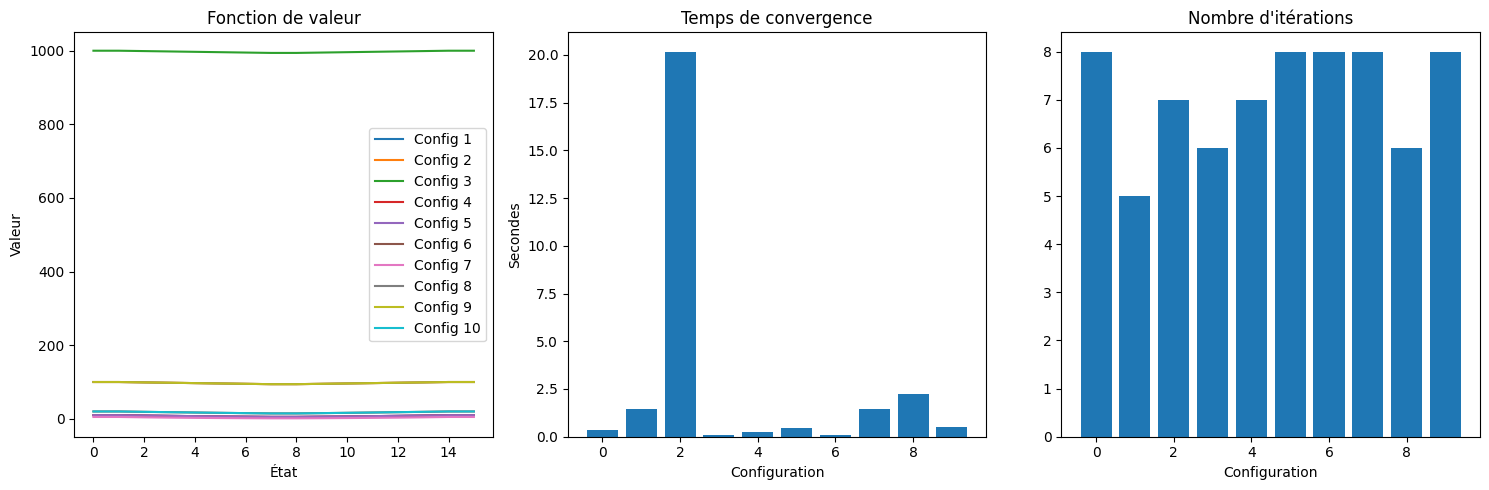

In [12]:
# Visualisation des résultats LineWorld
plt.figure(figsize=(15, 5))

# Fonction de valeur pour chaque configuration
plt.subplot(131)
for i, r in enumerate(results):
    plt.plot(r['V'], label=f"Config {i+1}")
plt.title('Fonction de valeur')
plt.xlabel('État')
plt.ylabel('Valeur')
plt.legend()

# Temps de convergence
plt.subplot(132)
plt.bar(range(len(results)), [r['training_time'] for r in results])
plt.title('Temps de convergence')
plt.xlabel('Configuration')
plt.ylabel('Secondes')

# Nombre d'itérations
plt.subplot(133)
plt.bar(range(len(results)), [r['iterations'] for r in results])
plt.title('Nombre d\'itérations')
plt.xlabel('Configuration')

plt.tight_layout()
plt.show()


In [13]:
# Test avec différents gamma et theta
params2 = [
    {'gamma': 0.9, 'theta': 1e-6},     # Configuration de base
    {'gamma': 0.99, 'theta': 1e-6},    # gamma plus élevé
    {'gamma': 0.999, 'theta': 1e-6}   # gamma très élevé
]


In [14]:
results = []
print("Test de Policy Iteration sur GridWorld :")

for i, p in enumerate(params2, 1):
    print(f"\nConfiguration {i}:")
    print(f"gamma = {p['gamma']}, theta = {p['theta']}")
    
    # Créer un nouvel environnement pour chaque configuration
    env = GridWorld(n_rows=5, n_cols=5)
    print("\nTest de la politique :")
    env.visualisation()
    
    # Initialisation et entraînement
    pi = PolicyIteration(env=env, gamma=p['gamma'], theta=p['theta'])
    start_time = time.time()
    result = pi.train(max_iterations=1000)
    training_time = time.time() - start_time
    
    # Test de la politique
    state = env.reset()
    total_reward = 0
    done = False
    step_count = 0
    
    while not done:
        # PolicyIteration retourne une politique différente de ValueIteration
        # result['policy'] est un array d'indices d'actions, pas une matrice de probabilités
        action = int(result['policy'][state])
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state
        env.visualisation()
        step_count += 1
        
    results.append({
        'V': result['V'],
        'iterations': result['iterations'],
        'training_time': training_time,
        'total_reward': total_reward,
        'step_count': step_count
    })
    
    print(f"\nRésultats :")
    print(f"Convergence en {result['iterations']} itérations")
    print(f"Temps d'entraînement : {training_time:.2f} secondes")
    print(f"Récompense totale : {total_reward}")
    print(f"Nombre de pas : {step_count}")

# Sauvegarder les résultats GridWorld
results_grid = results


Test de Policy Iteration sur GridWorld :

Configuration 1:
gamma = 0.9, theta = 1e-06

Test de la politique :

               Grid World               
----------------------------------------
+---+---+---+---+---+
|[T]|[ ]|[ ]|[ ]|[ ]|
+---+---+---+---+---+
|[ ]|[ ]|[ ]|[ ]|[ ]|
+---+---+---+---+---+
|[ ]|[ ]|[A]|[ ]|[ ]|
+---+---+---+---+---+
|[ ]|[ ]|[ ]|[ ]|[ ]|
+---+---+---+---+---+
|[ ]|[ ]|[ ]|[ ]|[T]|
+---+---+---+---+---+
Position de l'agent : (2,2)
Convergence atteinte après 5 itérations

               Grid World               
----------------------------------------
+---+---+---+---+---+
|[T]|[ ]|[ ]|[ ]|[ ]|
+---+---+---+---+---+
|[ ]|[ ]|[ ]|[ ]|[ ]|
+---+---+---+---+---+
|[ ]|[A]|[ ]|[ ]|[ ]|
+---+---+---+---+---+
|[ ]|[ ]|[ ]|[ ]|[ ]|
+---+---+---+---+---+
|[ ]|[ ]|[ ]|[ ]|[T]|
+---+---+---+---+---+
Position de l'agent : (2,1)

               Grid World               
----------------------------------------
+---+---+---+---+---+
|[T]|[ ]|[ ]|[ ]|[ ]|
+---+---+---+---+

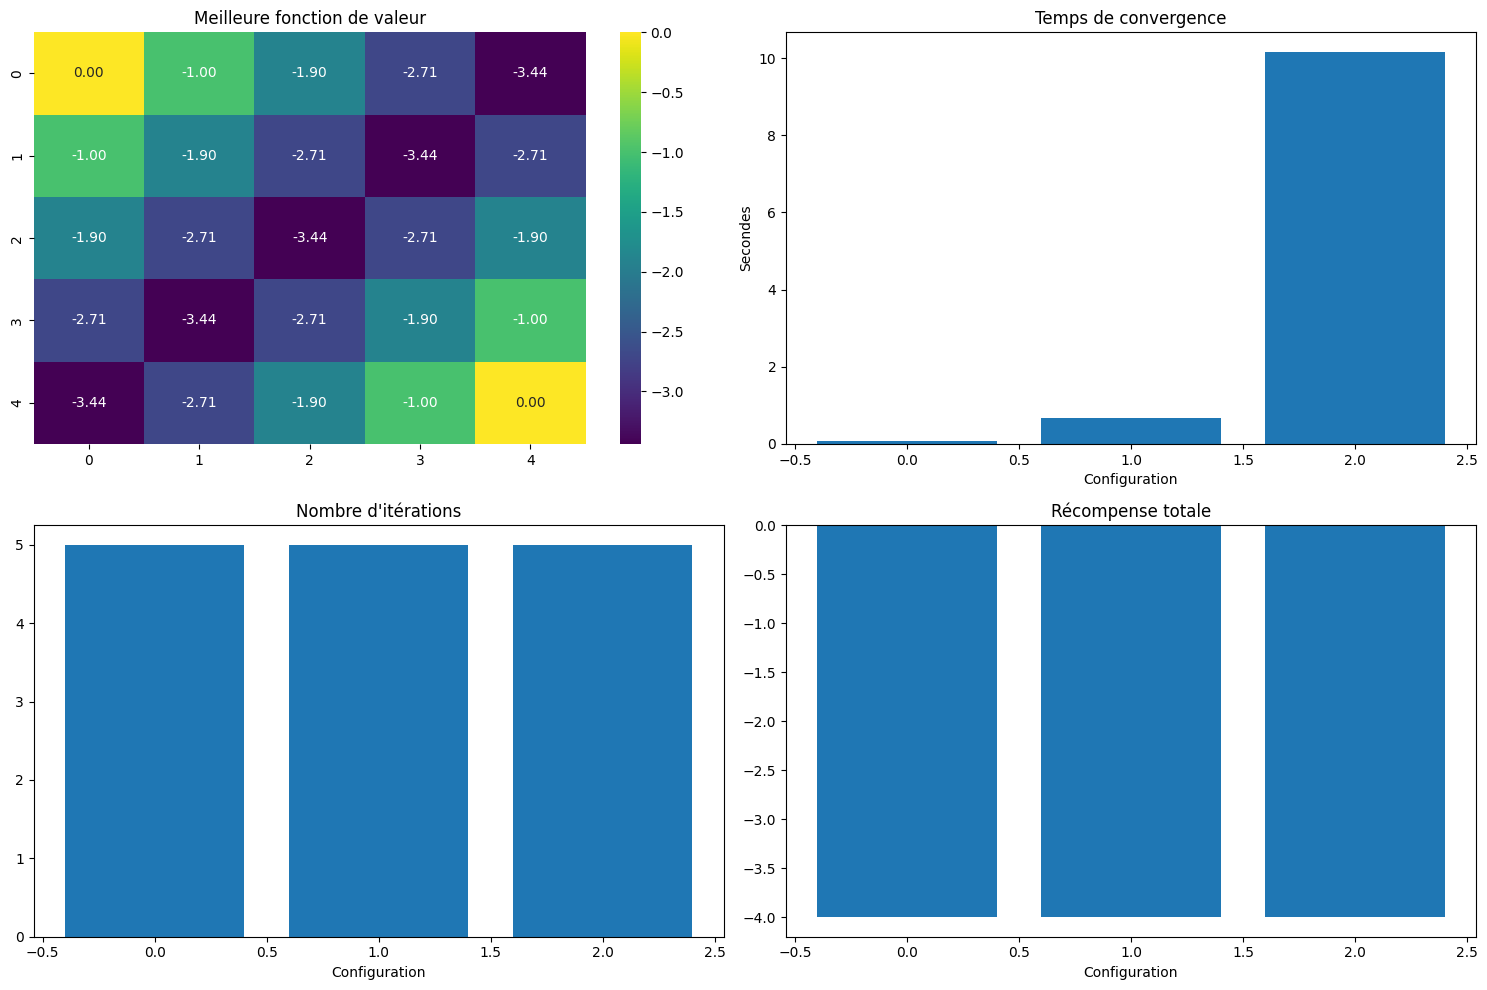

In [15]:
# Visualisation des résultats GridWorld
plt.figure(figsize=(15, 10))

# Fonction de valeur (heatmap) pour la meilleure configuration
best_result = max(results, key=lambda x: x['total_reward'])
V_grid = best_result['V'].reshape(5, 5)

plt.subplot(221)
sns.heatmap(V_grid, annot=True, fmt='.2f', cmap='viridis')
plt.title('Meilleure fonction de valeur')

# Temps de convergence
plt.subplot(222)
plt.bar(range(len(results)), [r['training_time'] for r in results])
plt.title('Temps de convergence')
plt.xlabel('Configuration')
plt.ylabel('Secondes')

# Nombre d'itérations
plt.subplot(223)
plt.bar(range(len(results)), [r['iterations'] for r in results])
plt.title('Nombre d\'itérations')
plt.xlabel('Configuration')

# Récompenses totales
plt.subplot(224)
plt.bar(range(len(results)), [r['total_reward'] for r in results])
plt.title('Récompense totale')
plt.xlabel('Configuration')

plt.tight_layout()
plt.show()


In [16]:
# Initialisation de l'environnement
env = RockPaperScissors()

results = []
print("Test de Policy Iteration sur Rock Paper Scissors :")

for i, p in enumerate(params, 1):
    print(f"\nConfiguration {i}:")
    print(f"gamma = {p['gamma']}, theta = {p['theta']}")
    
    # Initialisation et entraînement
    pi = PolicyIteration(env=env, gamma=p['gamma'], theta=p['theta'])
    start_time = time.time()
    result = pi.train(max_iterations=1000)
    training_time = time.time() - start_time
    
    # Test de la politique
    state = env.reset()
    total_reward = 0
    done = False
    step_count = 0
    actions_history = []
    
    print("\nTest de la politique :")
    env.visualisation()
    
    while not done:
        # PolicyIteration retourne une politique différente de ValueIteration
        # result['policy'] est un array d'indices d'actions, pas une matrice de probabilités
        action = int(result['policy'][state])
        actions_history.append(action)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state
        env.visualisation()
        step_count += 1
        
    results.append({
        'V': result['V'],
        'policy': result['policy'],
        'iterations': result['iterations'],
        'training_time': training_time,
        'total_reward': total_reward,
        'step_count': step_count,
        'actions': actions_history
    })
    
    print(f"\nRésultats :")
    print(f"Convergence en {result['iterations']} itérations")
    print(f"Temps d'entraînement : {training_time:.2f} secondes")
    print(f"Récompense totale : {total_reward}")
    print(f"Séquence d'actions : {actions_history}")

# Sauvegarder les résultats RockPaperScissors
results_rps = results


Test de Policy Iteration sur Rock Paper Scissors :

Configuration 1:
gamma = 0.9, theta = 1e-06
Convergence atteinte après 2 itérations

Test de la politique :

               🎮 ROUND 🎮                
----------------------------------------
         🎲 Nouvelle partie ! 🎲          


               🎮 ROUND 🎮                
----------------------------------------
Vous      : 🪨  Pierre
Adversaire: 🪨  Pierre
----------------------------------------
           It's a tie ! Wow 🤝           


               🎮 ROUND 🎮                
----------------------------------------
Vous      : 📄  Feuille
Adversaire: 🪨  Pierre
----------------------------------------
    Winner winner chicken dinner ! 🎉    


Résultats :
Convergence en 2 itérations
Temps d'entraînement : 0.00 secondes
Récompense totale : 1
Séquence d'actions : [0, 1]

Configuration 2:
gamma = 0.99, theta = 1e-06
Convergence atteinte après 2 itérations

Test de la politique :

               🎮 ROUND 🎮                
--------------

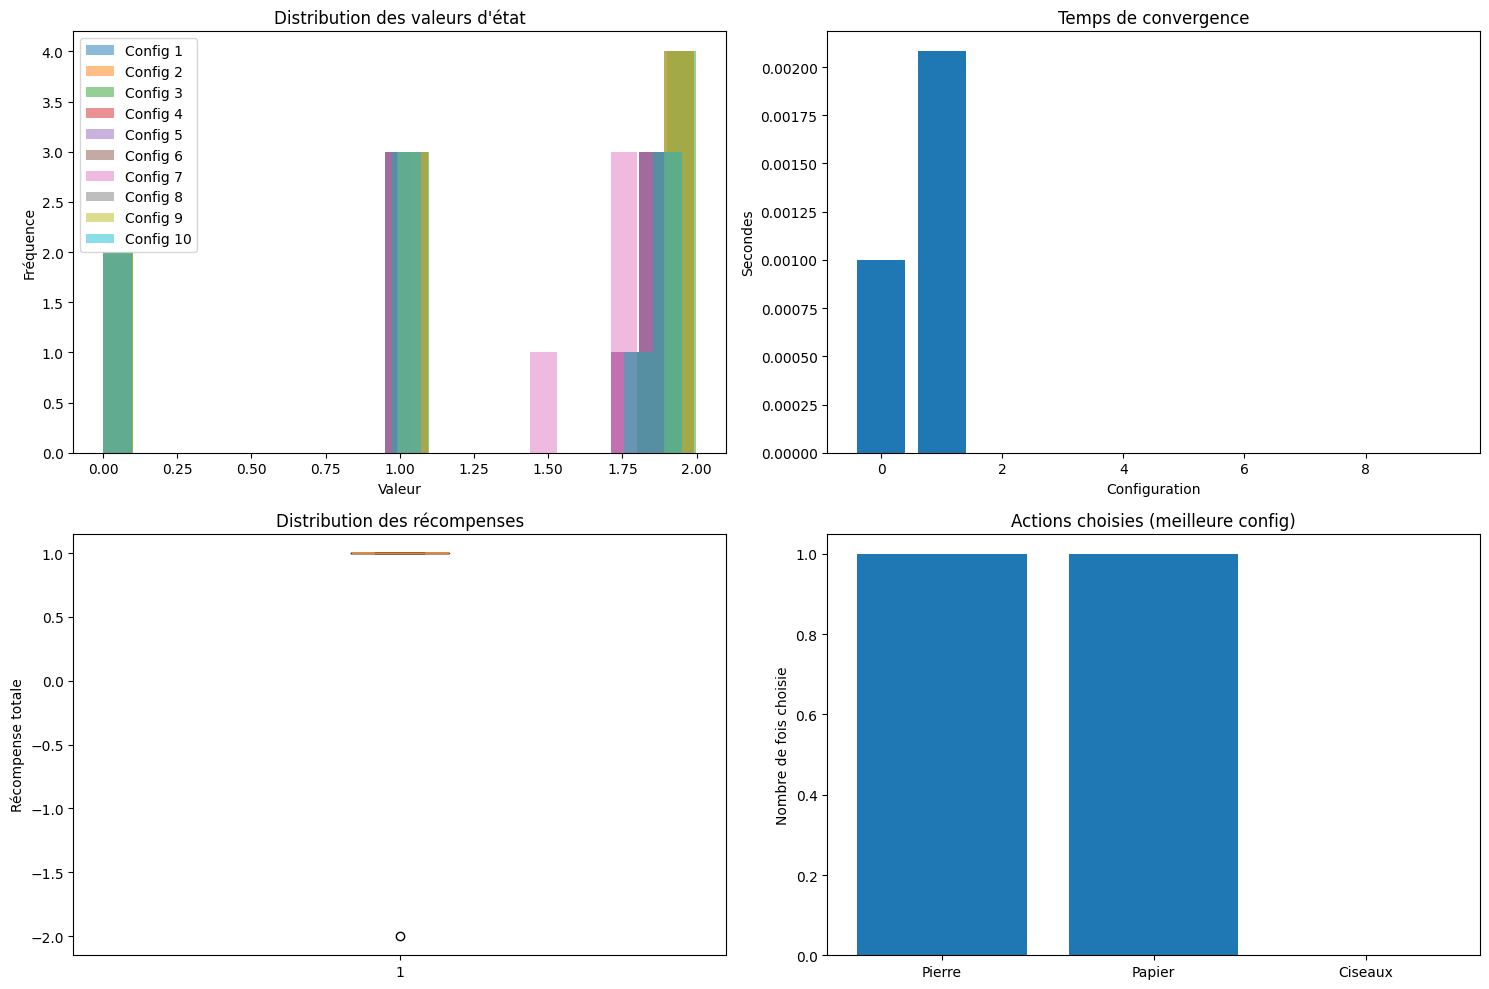

In [18]:
# Visualisation des résultats RockPaperScissors
plt.figure(figsize=(15, 10))

# Distribution des valeurs d'état
plt.subplot(221)
for i, r in enumerate(results):
    plt.hist(r['V'], alpha=0.5, label=f"Config {i+1}", bins=20)
plt.title('Distribution des valeurs d\'état')
plt.xlabel('Valeur')
plt.ylabel('Fréquence')
plt.legend()

# Temps de convergence
plt.subplot(222)
plt.bar(range(len(results)), [r['training_time'] for r in results])
plt.title('Temps de convergence')
plt.xlabel('Configuration')
plt.ylabel('Secondes')

# Distribution des récompenses
plt.subplot(223)
plt.boxplot([r['total_reward'] for r in results])
plt.title('Distribution des récompenses')
plt.ylabel('Récompense totale')

# Actions choisies (pour la meilleure configuration)
best_result = max(results, key=lambda x: x['total_reward'])
plt.subplot(224)
action_counts = np.bincount(best_result['actions'], minlength=3)
plt.bar(['Pierre', 'Papier', 'Ciseaux'], action_counts)
plt.title('Actions choisies (meilleure config)')
plt.ylabel('Nombre de fois choisie')

plt.tight_layout()
plt.show()


In [19]:
# MontyHallParadox1
env = MontyHallParadox1()

results = []
print("Test de Policy Iteration sur Monty Hall Niveau 1 (CORRIGÉ):")

for i, p in enumerate(params, 1):
    print(f"\nConfiguration {i}:")
    print(f"gamma = {p['gamma']}, theta = {p['theta']}")
    
    # Initialisation et entraînement
    pi = PolicyIteration(env=env, gamma=p['gamma'], theta=p['theta'])
    start_time = time.time()
    result = pi.train(max_iterations=1000)
    training_time = time.time() - start_time
    
    # Test de la politique sur plusieurs épisodes
    n_episodes = 100
    total_rewards = []
    switch_rates = []
    success_rates = []
    
    for _ in range(n_episodes):
        # Créer une nouvelle instance pour chaque épisode
        episode_env = MontyHallParadox1()
        state = episode_env.reset()
        total_reward = 0
        done = False
        switched = False
        step_count = 0
        max_steps = 10  # Limite pour éviter les boucles infinies
        
        while not done and step_count < max_steps:
            # Convertir l'état en index numérique pour accéder à la politique
            if isinstance(state, str):
                if state == "terminal":
                    break
                state_idx = episode_env.state_to_idx[state]
            else:  # tuple
                state_idx = episode_env.state_to_idx[state]
            
            # Choisir l'action selon la politique apprise (PolicyIteration)
            action = int(result['policy'][state_idx])
            
            # Détecter si on est en phase 2 (décision finale)
            if isinstance(state, tuple) and len(state) == 2:
                switched = (action == 1)  # 1 = changer de porte
                
            next_state, reward, done, info = episode_env.step(action)
            total_reward += reward
            state = next_state
            step_count += 1
            
        total_rewards.append(total_reward)
        switch_rates.append(switched)
        success_rates.append(total_reward > 0)
    
    results.append({
        'V': result['V'],
        'iterations': result['iterations'],
        'training_time': training_time,
        'avg_reward': np.mean(total_rewards),
        'switch_rate': np.mean(switch_rates),
        'success_rate': np.mean(success_rates)
    })
    
    print(f"\nRésultats :")
    print(f"Convergence en {result['iterations']} itérations")
    print(f"Temps d'entraînement : {training_time:.2f} secondes")
    print(f"Taux de changement de porte : {results[-1]['switch_rate']:.2%}")
    print(f"Taux de succès : {results[-1]['success_rate']:.2%}")

# Sauvegarder les résultats MontyHallParadox1
results_mh1 = results


Test de Policy Iteration sur Monty Hall Niveau 1 (CORRIGÉ):

Configuration 1:
gamma = 0.9, theta = 1e-06
Convergence atteinte après 2 itérations

Résultats :
Convergence en 2 itérations
Temps d'entraînement : 0.00 secondes
Taux de changement de porte : 100.00%
Taux de succès : 69.00%

Configuration 2:
gamma = 0.99, theta = 1e-06
Convergence atteinte après 2 itérations

Résultats :
Convergence en 2 itérations
Temps d'entraînement : 0.00 secondes
Taux de changement de porte : 100.00%
Taux de succès : 70.00%

Configuration 3:
gamma = 0.999, theta = 1e-06
Convergence atteinte après 2 itérations

Résultats :
Convergence en 2 itérations
Temps d'entraînement : 0.00 secondes
Taux de changement de porte : 100.00%
Taux de succès : 69.00%

Configuration 4:
gamma = 0.9, theta = 0.0001
Convergence atteinte après 3 itérations

Résultats :
Convergence en 3 itérations
Temps d'entraînement : 0.00 secondes
Taux de changement de porte : 100.00%
Taux de succès : 58.00%

Configuration 5:
gamma = 0.9, theta

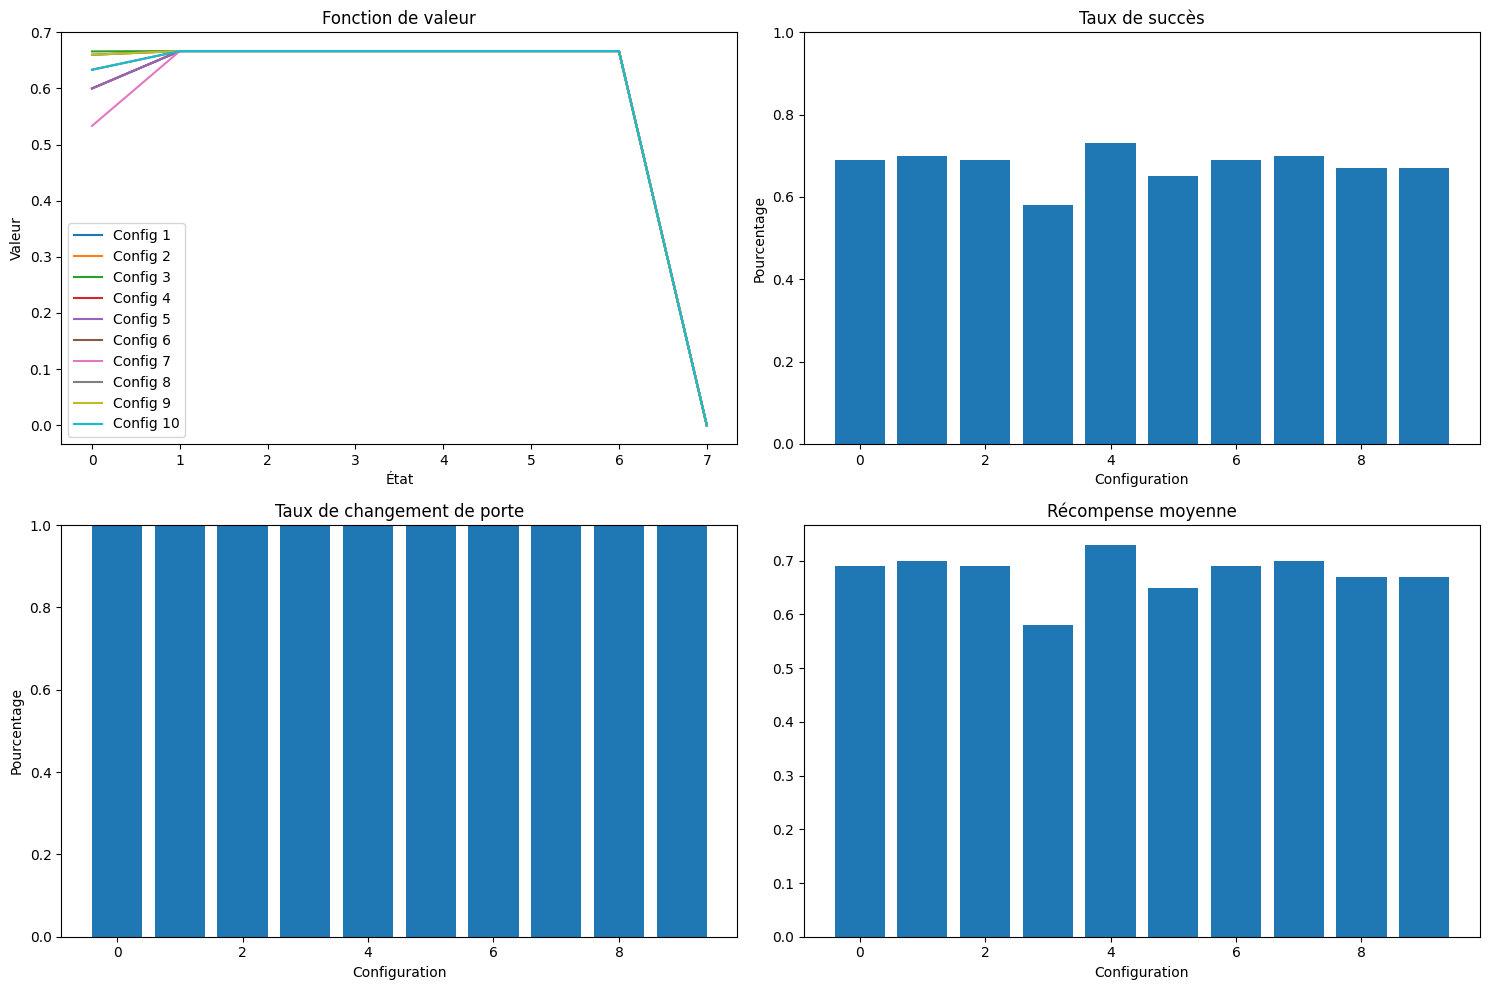

In [20]:
# Visualisation des résultats Monty Hall Niveau 1
plt.figure(figsize=(15, 10))

# Fonction de valeur pour chaque configuration
plt.subplot(221)
for i, r in enumerate(results):
    plt.plot(r['V'], label=f"Config {i+1}")
plt.title('Fonction de valeur')
plt.xlabel('État')
plt.ylabel('Valeur')
plt.legend()

# Taux de succès
plt.subplot(222)
plt.bar(range(len(results)), [r['success_rate'] for r in results])
plt.title('Taux de succès')
plt.xlabel('Configuration')
plt.ylabel('Pourcentage')
plt.ylim(0, 1)

# Taux de changement de porte
plt.subplot(223)
plt.bar(range(len(results)), [r['switch_rate'] for r in results])
plt.title('Taux de changement de porte')
plt.xlabel('Configuration')
plt.ylabel('Pourcentage')
plt.ylim(0, 1)

# Récompense moyenne
plt.subplot(224)
plt.bar(range(len(results)), [r['avg_reward'] for r in results])
plt.title('Récompense moyenne')
plt.xlabel('Configuration')

plt.tight_layout()
plt.show()


In [21]:
# Initialisation de l'environnement
env = MontyHallParadox2()

results = []
print("Test de Policy Iteration sur Monty Hall Niveau 2 :")

for i, p in enumerate(params, 1):
    print(f"\nConfiguration {i}:")
    print(f"gamma = {p['gamma']}, theta = {p['theta']}")
    
    # Initialisation et entraînement
    pi = PolicyIteration(env=env, gamma=p['gamma'], theta=p['theta'])
    start_time = time.time()
    result = pi.train(max_iterations=1000)
    training_time = time.time() - start_time
    
    # Test de la politique sur plusieurs épisodes
    n_episodes = 100
    total_rewards = []
    switch_counts = []
    success_rates = []
    
    for _ in range(n_episodes):
        # Créer une nouvelle instance pour chaque épisode
        episode_env = MontyHallParadox2()
        state = episode_env.reset()
        total_reward = 0
        done = False
        switches = 0
        step_count = 0
        max_steps = 10  # Limite pour éviter les boucles infinies
        
        while not done and step_count < max_steps:
            # Convertir l'état en index numérique pour accéder à la politique
            if isinstance(state, str):
                if state == "terminal":
                    break
                state_idx = episode_env.state_to_idx[state]
            else:  # tuple
                state_idx = episode_env.state_to_idx[state]
            
            # Choisir l'action selon la politique apprise (PolicyIteration)
            action = int(result['policy'][state_idx])
            
            # Compter les changements en phase finale (phase 3)
            if isinstance(state, tuple) and len(state) == 3 and state[0] == 3:
                switches += (action == 1)  # 1 = changer de porte
            
            next_state, reward, done, info = episode_env.step(action)
            total_reward += reward
            state = next_state
            step_count += 1
            
        total_rewards.append(total_reward)
        switch_counts.append(switches)
        success_rates.append(total_reward > 0)
    
    results.append({
        'V': result['V'],
        'iterations': result['iterations'],
        'training_time': training_time,
        'avg_reward': np.mean(total_rewards),
        'avg_switches': np.mean(switch_counts),
        'success_rate': np.mean(success_rates)
    })
    
    print(f"\nRésultats :")
    print(f"Convergence en {result['iterations']} itérations")
    print(f"Temps d'entraînement : {training_time:.2f} secondes")
    print(f"Nombre moyen de changements : {results[-1]['avg_switches']:.2f}")
    print(f"Taux de succès : {results[-1]['success_rate']:.2%}")

# Sauvegarder les résultats MontyHallParadox2
results_mh2 = results


Test de Policy Iteration sur Monty Hall Niveau 2 :

Configuration 1:
gamma = 0.9, theta = 1e-06
Convergence atteinte après 4 itérations

Résultats :
Convergence en 4 itérations
Temps d'entraînement : 0.11 secondes
Nombre moyen de changements : 1.00
Taux de succès : 68.00%

Configuration 2:
gamma = 0.99, theta = 1e-06
Convergence atteinte après 4 itérations

Résultats :
Convergence en 4 itérations
Temps d'entraînement : 0.10 secondes
Nombre moyen de changements : 1.00
Taux de succès : 74.00%

Configuration 3:
gamma = 0.999, theta = 1e-06
Convergence atteinte après 4 itérations

Résultats :
Convergence en 4 itérations
Temps d'entraînement : 0.10 secondes
Nombre moyen de changements : 1.00
Taux de succès : 72.00%

Configuration 4:
gamma = 0.9, theta = 0.0001
Convergence atteinte après 4 itérations

Résultats :
Convergence en 4 itérations
Temps d'entraînement : 0.10 secondes
Nombre moyen de changements : 1.00
Taux de succès : 73.00%

Configuration 5:
gamma = 0.9, theta = 1e-08
Convergence 

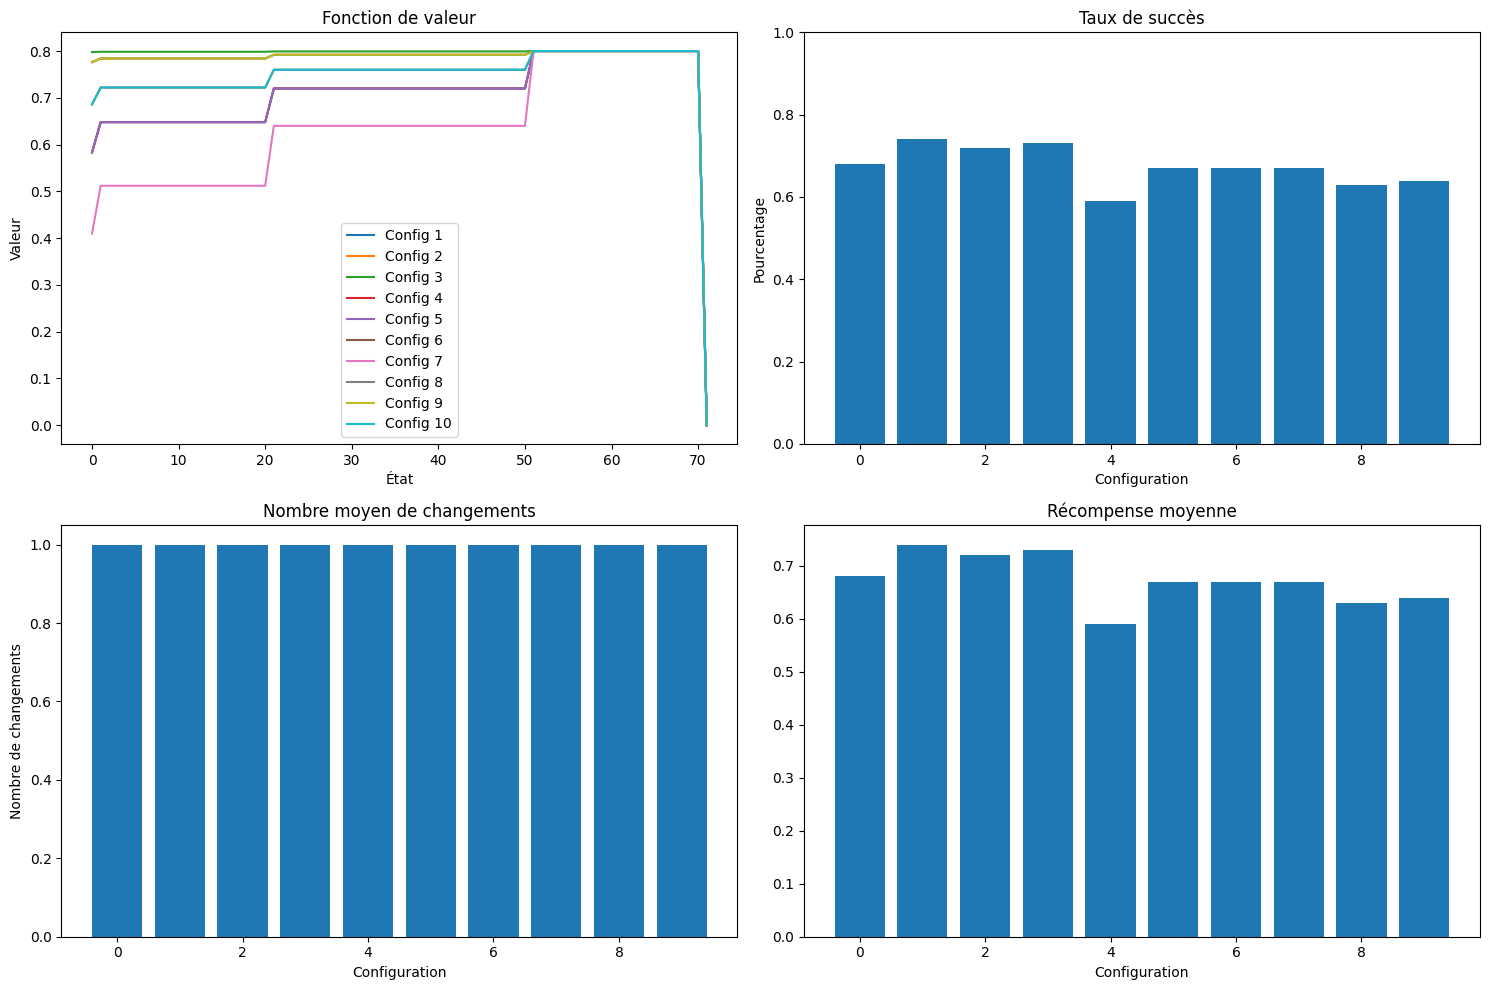

In [22]:
# Visualisation des résultats Monty Hall Niveau 2
plt.figure(figsize=(15, 10))

# Fonction de valeur pour chaque configuration
plt.subplot(221)
for i, r in enumerate(results):
    plt.plot(r['V'], label=f"Config {i+1}")
plt.title('Fonction de valeur')
plt.xlabel('État')
plt.ylabel('Valeur')
plt.legend()

# Taux de succès
plt.subplot(222)
plt.bar(range(len(results)), [r['success_rate'] for r in results])
plt.title('Taux de succès')
plt.xlabel('Configuration')
plt.ylabel('Pourcentage')
plt.ylim(0, 1)

# Nombre moyen de changements
plt.subplot(223)
plt.bar(range(len(results)), [r['avg_switches'] for r in results])
plt.title('Nombre moyen de changements')
plt.xlabel('Configuration')
plt.ylabel('Nombre de changements')

# Récompense moyenne
plt.subplot(224)
plt.bar(range(len(results)), [r['avg_reward'] for r in results])
plt.title('Récompense moyenne')
plt.xlabel('Configuration')

plt.tight_layout()
plt.show()


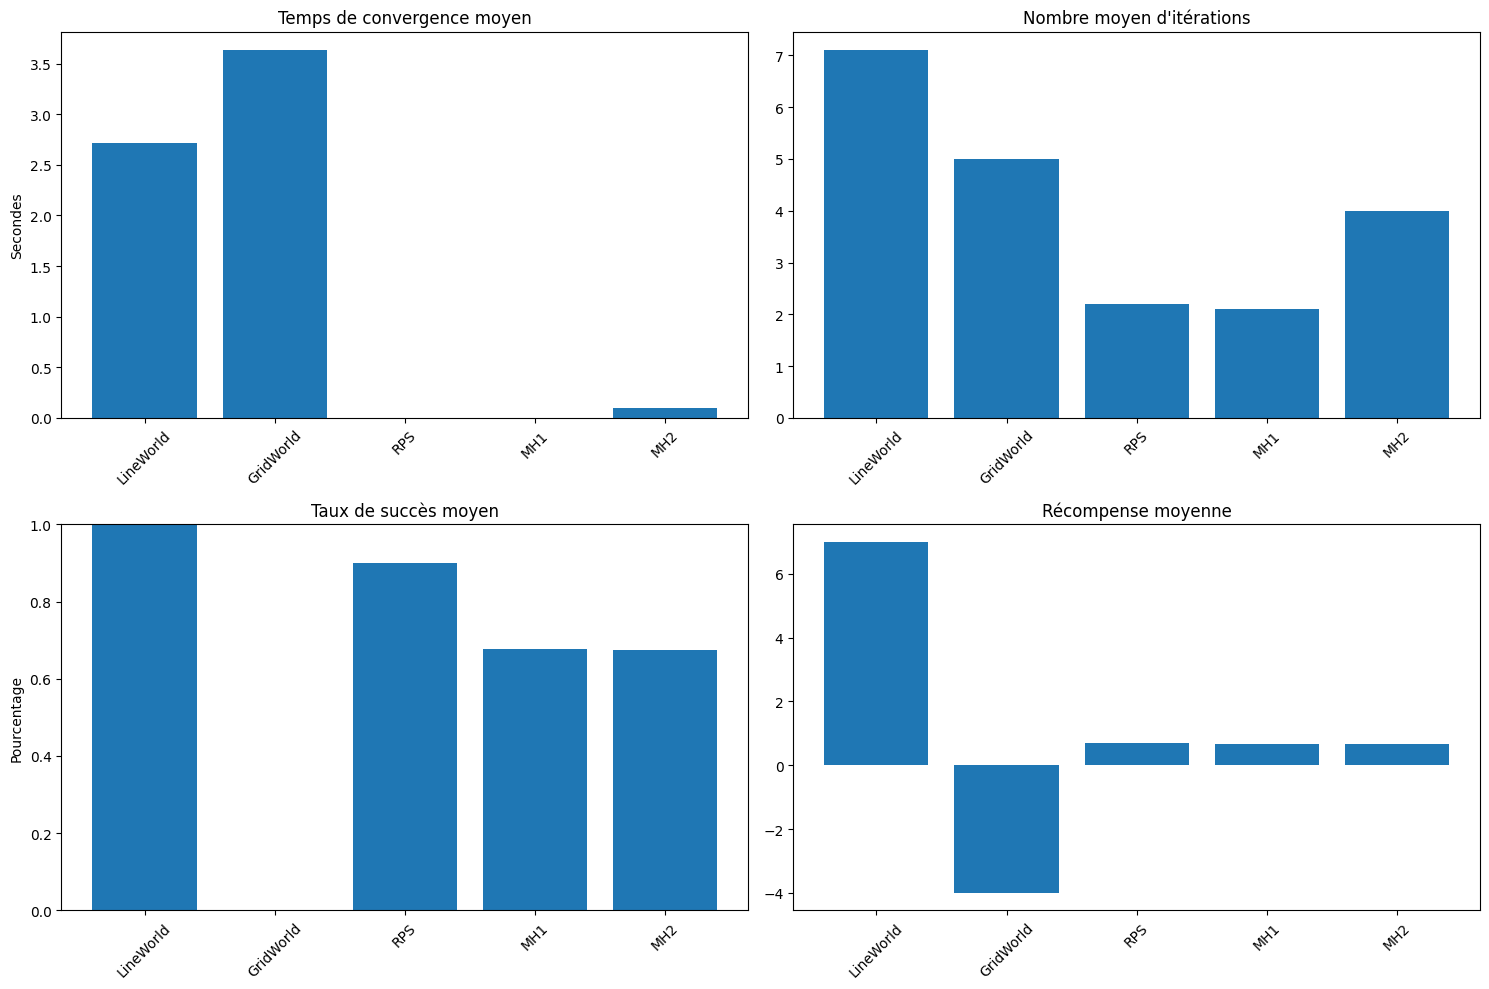

=== RÉSUMÉ COMPARATIF POLICY ITERATION ===

LineWorld:
  - Temps moyen: 2.713s
  - Itérations moyennes: 7.1
  - Taux de succès: 100.0%
  - Récompense moyenne: 7.000

GridWorld:
  - Temps moyen: 3.633s
  - Itérations moyennes: 5.0
  - Taux de succès: 0.0%
  - Récompense moyenne: -4.000

RPS:
  - Temps moyen: 0.000s
  - Itérations moyennes: 2.2
  - Taux de succès: 90.0%
  - Récompense moyenne: 0.700

MH1:
  - Temps moyen: 0.001s
  - Itérations moyennes: 2.1
  - Taux de succès: 67.7%
  - Récompense moyenne: 0.677

MH2:
  - Temps moyen: 0.101s
  - Itérations moyennes: 4.0
  - Taux de succès: 67.4%
  - Récompense moyenne: 0.674



In [23]:
# Comparaison globale des environnements
plt.figure(figsize=(15, 10))

env_names = ['LineWorld', 'GridWorld', 'RPS', 'MH1', 'MH2']
all_results = [results_line, results_grid, results_rps, results_mh1, results_mh2]

# Temps de convergence moyen
plt.subplot(221)
avg_times = [np.mean([r['training_time'] for r in res]) for res in all_results]
plt.bar(env_names, avg_times)
plt.title('Temps de convergence moyen')
plt.ylabel('Secondes')
plt.xticks(rotation=45)

# Nombre moyen d'itérations
plt.subplot(222)
avg_iterations = [np.mean([r['iterations'] for r in res]) for res in all_results]
plt.bar(env_names, avg_iterations)
plt.title('Nombre moyen d\'itérations')
plt.xticks(rotation=45)

# Taux de succès moyen (avec gestion des différents formats de résultats)
plt.subplot(223)
success_rates = []
for res in all_results:
    if 'success_rate' in res[0]:  # MontyHall environnements
        success_rates.append(np.mean([r['success_rate'] for r in res]))
    else:  # Autres environnements - utiliser total_reward > 0
        success_rates.append(np.mean([r['total_reward'] > 0 for r in res]))
        
plt.bar(env_names, success_rates)
plt.title('Taux de succès moyen')
plt.ylabel('Pourcentage')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Récompense moyenne
plt.subplot(224)
avg_rewards = []
for res in all_results:
    if 'avg_reward' in res[0]:  # MontyHall environnements
        avg_rewards.append(np.mean([r['avg_reward'] for r in res]))
    else:  # Autres environnements
        avg_rewards.append(np.mean([r['total_reward'] for r in res]))
        
plt.bar(env_names, avg_rewards)
plt.title('Récompense moyenne')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Affichage des statistiques numériques
print("=== RÉSUMÉ COMPARATIF POLICY ITERATION ===\n")
for i, env_name in enumerate(env_names):
    print(f"{env_name}:")
    print(f"  - Temps moyen: {avg_times[i]:.3f}s")
    print(f"  - Itérations moyennes: {avg_iterations[i]:.1f}")
    print(f"  - Taux de succès: {success_rates[i]:.1%}")
    print(f"  - Récompense moyenne: {avg_rewards[i]:.3f}")
    print()
